<a href="https://colab.research.google.com/github/oscar-defelice/TimeSeries-lectures/blob/development/exercises/ExerciseForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis and Forecasting

This is a series of notebooks to support lectures on _Time series analysis and forecast_.

![](https://user-images.githubusercontent.com/49638680/154160268-cf39a1ec-3557-4940-8853-d06fc7a79acf.png)

## Time series Forecast - Exercise

In paticular, over this notebook we are going to perform an exercise about time series forecast.

### Preliminaries
We need to import a self-written module and to upgrade libraries in this environment.

In [10]:
%%bash
mkdir utils
wget -P utils/ https://raw.githubusercontent.com/oscar-defelice/TimeSeries-lectures/main/utils/helpers.py

mkdir: cannot create directory ‘utils’: File exists
--2022-03-05 15:06:55--  https://raw.githubusercontent.com/oscar-defelice/TimeSeries-lectures/main/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1152 (1.1K) [text/plain]
Saving to: ‘utils/helpers.py.1’

     0K .                                                     100% 47.1M=0s

2022-03-05 15:06:55 (47.1 MB/s) - ‘utils/helpers.py.1’ saved [1152/1152]



In [11]:
%%bash
pip install --upgrade -q prophet statsmodels

### Import libraries and data

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from utils.helpers import regression_results, rmse, parser

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 10.0)
sns.set()

### The dataset
This dataset describes a monthly count of the number of observed sunspots for just over 230 years ($1749$-$1983$).

The units are a count and there are $2820$ observations. The source of the dataset is credited to Andrews & Herzberg ($1985$).

In [13]:
data_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv"

In [14]:
df = pd.read_csv(data_url,
                 parse_dates=True,
                 index_col='Month')

df

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


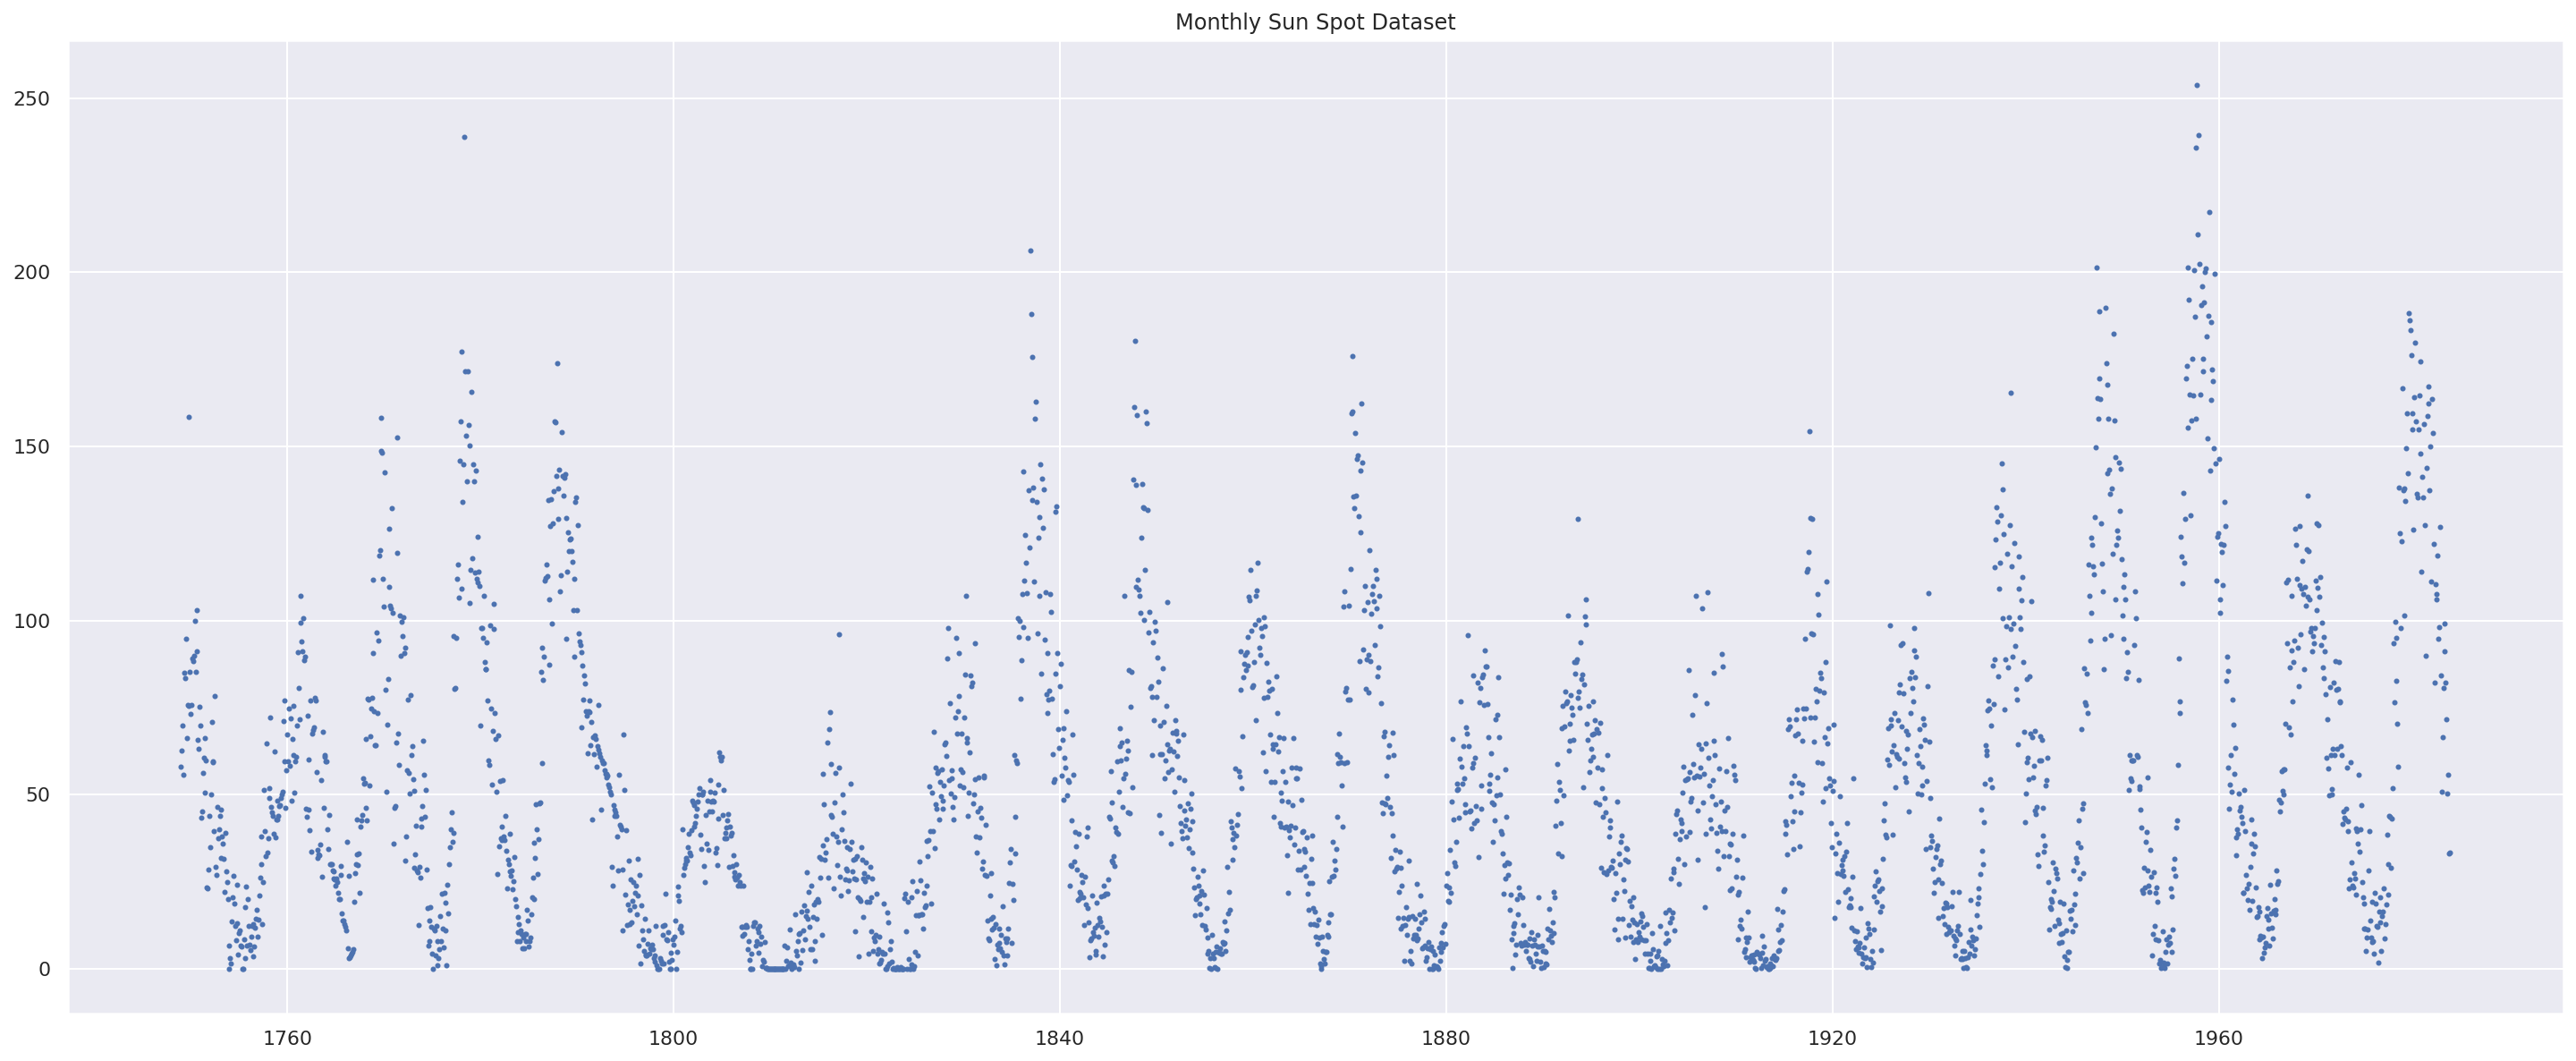

In [15]:
plt.plot(df,
         marker='.',
         markersize=4,
         linestyle='')
plt.title('Monthly Sun Spot Dataset');

## The exercise

Analyse the time series decomposition.

Forecast the number of observed sunspot in the next year. 

Discuss the hyperparameter choices.

## Prophet Forecast

In [50]:
df_train = df.loc[:'1970']
df_test = df.loc['1971':]

In [51]:
df_prophet_train = df_train.reset_index()

df_prophet_train.columns = ['ds', 'y']

In [52]:
df_prophet_train

,ds,y
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0
...,...,...
2659,1970-08-01,93.0
2660,1970-09-01,99.5
2661,1970-10-01,86.6
2662,1970-11-01,95.2


In [113]:
model = Prophet(seasonality_mode = 'multiplicative')
model.add_seasonality(name='11yr', period=365.25 * 11, fourier_order=5)
model.add_seasonality(name='2yr', period=365.25 * 2, fourier_order=5)
model.fit(df_prophet_train);

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [114]:
df_test

,Sunspots,Predictions
Month,,
1971-01-01,91.3,137.684034
1971-02-01,79.0,133.040032
1971-03-01,60.7,139.787416
1971-04-01,71.8,129.815835
1971-05-01,57.5,131.222396
...,...,...
1983-08-01,71.8,125.462337
1983-09-01,50.3,116.674812
1983-10-01,55.8,112.870783


In [115]:
future = model.make_future_dataframe(periods=156, include_history=False, freq='M')
future

,ds
0,1970-12-31
1,1971-01-31
2,1971-02-28
3,1971-03-31
4,1971-04-30
...,...
151,1983-07-31
152,1983-08-31
153,1983-09-30
154,1983-10-31


In [116]:
test_predictions = model.predict(future)

In [117]:
test_predictions['ds'] = test_predictions['ds'].apply(lambda x: x + pd.DateOffset(1)) 

In [118]:
test_predictions[['ds','yhat']]

,ds,yhat
0,1971-01-01,137.540468
1,1971-02-01,131.391552
2,1971-03-01,137.672207
3,1971-04-01,128.073454
4,1971-05-01,130.871379
...,...,...
151,1983-08-01,126.087116
152,1983-09-01,118.218261
153,1983-10-01,115.151251
154,1983-11-01,99.334380


In [119]:
df_test['Predictions'] = test_predictions.yhat.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [120]:
df_test

,Sunspots,Predictions
Month,,
1971-01-01,91.3,137.540468
1971-02-01,79.0,131.391552
1971-03-01,60.7,137.672207
1971-04-01,71.8,128.073454
1971-05-01,57.5,130.871379
...,...,...
1983-08-01,71.8,126.087116
1983-09-01,50.3,118.218261
1983-10-01,55.8,115.151251


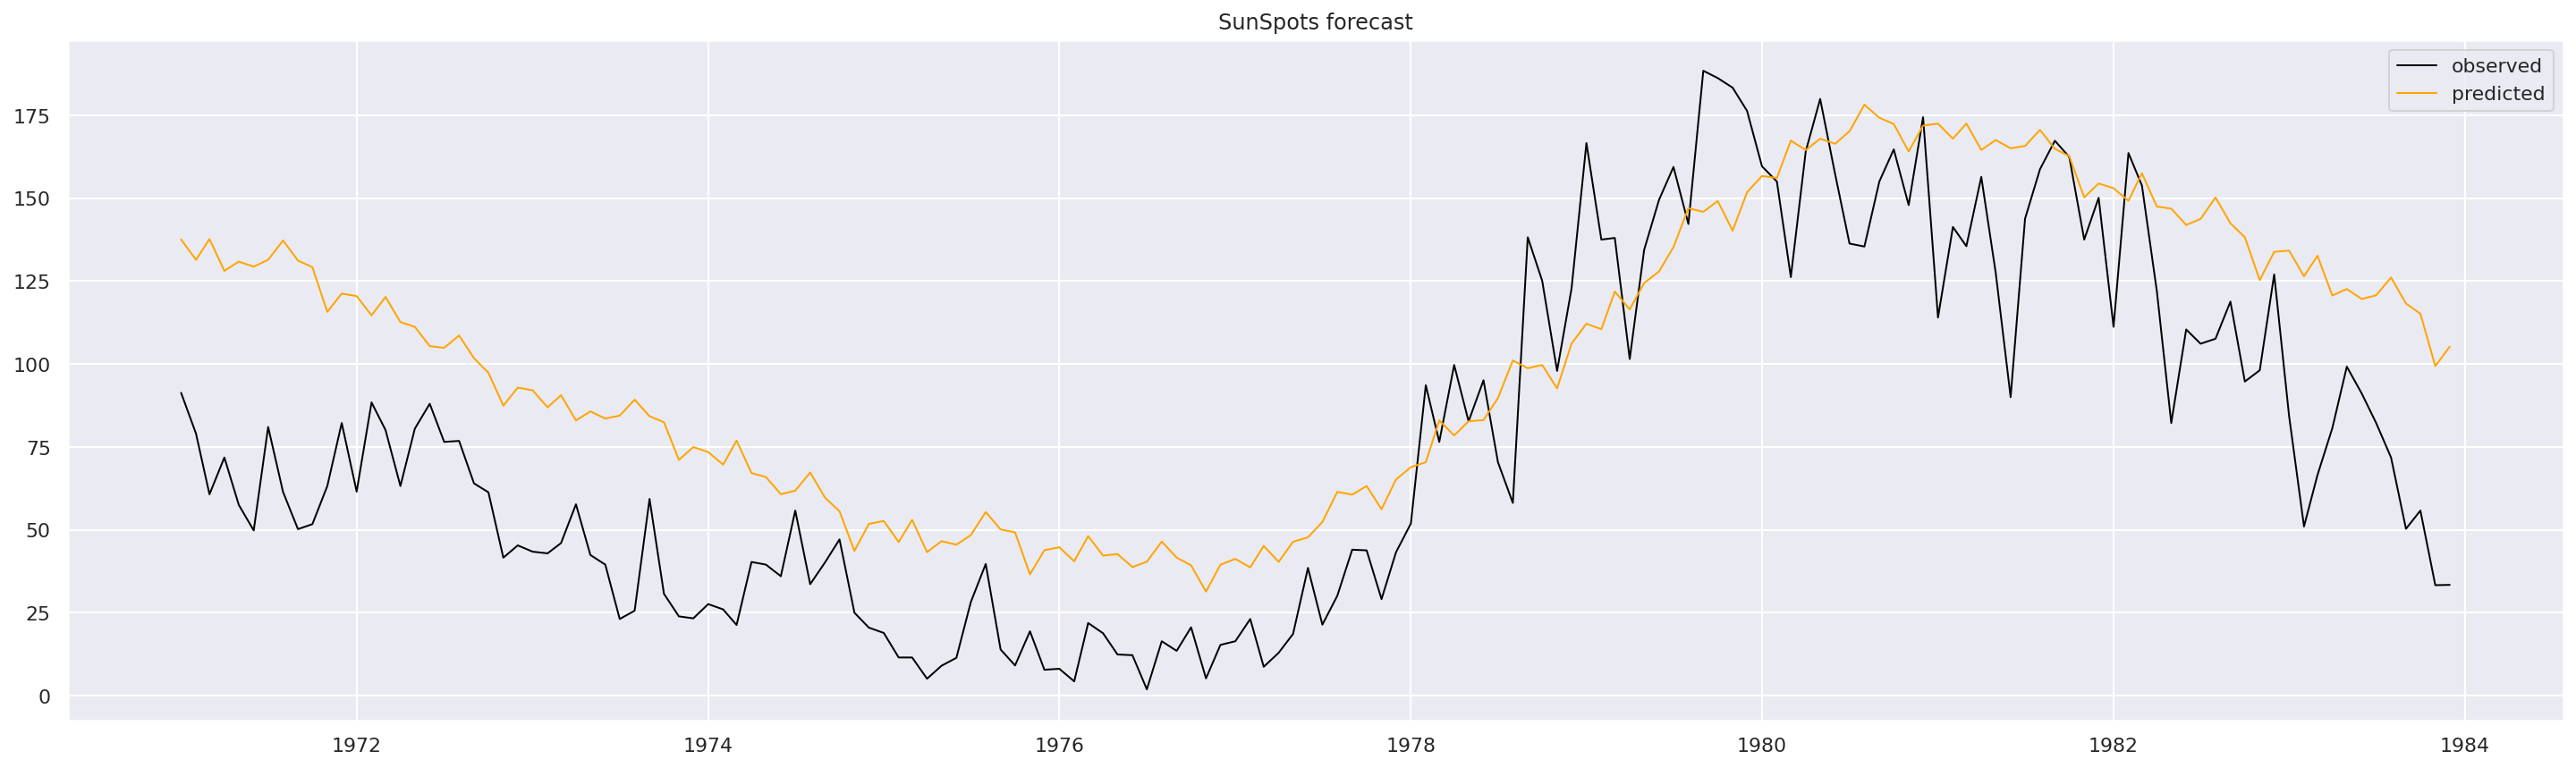

In [121]:
plt.figure(figsize=(25, 7))

plt.plot(df_test['Sunspots'],
         linestyle='-',
         color='black',
         linewidth=1,
         label='observed')

plt.plot(df_test['Predictions'],
         linestyle='-',
         linewidth=1,
         color='orange',
         label='predicted')

plt.title('SunSpots forecast')
plt.legend();